In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

## Introductory Exercise

With this lecture we will start to explore the topic of the simulations of Stochastic Differential Equations which will be the main topic of the tutoring sessions and we will analyze it under many different point of views and methods. For this first lecture we will solve a trivial problem and we will try to simulate the trajectories 
to obtain than the steady state probability distribution. The steady state probability distribution will be of fundamental importance because it's the starting point of the whole qualitative analysis of Stochastic Dynamic Systems.

**PROBLEM**: We want to model the classical problem of the perturbed logistic system. This system is characterize by the following Ito equation:

$$
dx=[rx-x^2]dt+axdW
$$

which is associated to the deterministic problem $x'=rx-x^2$ where $r\rightarrow r+a\xi(t)$.

We can also compute the probability distribution for our problem solving the associated FP equation:

$$
P_s(x)=Ax^{\frac{2r}{a^2}-2}e^{-\frac{2x}{a^2}}
$$

However there could be some problems now: in fact this probability distribution to be defined needs to set a correct normalization constant $A$ however this can be computed only when $P_s$ is integrable and this happens when $2r/a^2>1$ however this does not mean that outside of this region the distribution has no sense but it's simply not possible to compute the integral to obtain $A$ so we will need to set it manually or compute it using other methods and tools.

### Step 1

Let's start to understand how to simulate the SDE. If it was a normal differential equation it would be quite an easy task: we can simply estimate the evolution using a FD methods such as the RK4. So our general idea is to implement a trajectory computation method that will use RK4 adding the stochastic contribution. About error the major issue will be to find a good random algorithm so we will use the **pcg**.

In [2]:
from numpy.random import Generator, PCG64

**MEMO 1**: The RK4 method is a FD forward method of order $O(h^4)$ for the cumulative error (error on the last point). Given an DS with formula

$$
\frac{dy}{dt}=f(t,y),\qquad y(t_0)=y_0
$$

the iterative map that will give us the point of the trajectory is:

$$
y_{n+1}=y_{n}+\frac{h}{6}(k_1+2k_2+2k_3+k_4)
$$

where

$$
k_1=f(t_n,y_n),\qquad k_2=f\left(t_n+\frac{h}{2},y_n+h\frac{k_1}{2}\right),\qquad k_3=f\left(t_n+\frac{h}{2},y_n+h\frac{k_2}{2}\right),\qquad k_4=f(t_n+h,y_n+hk_3)
$$

**MEMO 2**: To simulate a white noise we can use the fact that $dW=G(t)\sqrt{dt}$ where $G(t)$ is a normal random value

In [3]:
class PLS(object):
    '''
    This function will simulate trajectories for an initialize
    perturbed logistic system
    '''

    #CONSTRUCTOR
    def __init__(self,r: float,a: float)->None:
        self.r = r
        self.a = a
        
        #No check are needed because the system works for all the values but maybe 
        #for certain it's not meaningful
        
        return

    def __checkInputs(self,x0: float,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        #x0 checks:
        if x0<0:
            raise RuntimeError("Initial population must be positive")

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the PLS
        '''
        #Perform the check of the inputs. For N we hard code a good N.
        self.__checkInputs(y_n,t_n,10)
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: self.r*x-x*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the PLS.
        '''
        #Check the inputs
        self.__checkInputs(x0,T,N)

        if T==0:
            return np.array([x0])

        #Setup step lenght and traj array
        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        #Setup random generator
        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) #determinstic part
            dx += self.a*traj[i-1]*rng.normal()*np.sqrt(h) #noise part
            traj[i] = traj[i-1] + dx

        return traj,time

In [4]:
system = PLS(15,

tr1, time1 = system.simulateTraj(1,10,500)
print(tr1)

[ 1.          1.31988791  1.92400614  2.78751995  3.91173936  4.1320548
  5.02103419  5.89616712  6.85400414  8.3105641   7.97249011  7.86271393
 10.02260553 10.884394   12.37843728 12.46584946 10.73403566 12.88785778
 11.61670499 10.57473829 12.87547143 12.59194408 13.49169402 12.61625595
 16.18643258 14.04154006 13.54828873 15.18455511 16.39178503 18.77121042
 22.07797599 20.60821847 21.44649069 25.11461206 19.48469773 21.59842844
 17.41430278 13.96650704 15.28577203 19.04526517 18.48310191 18.42573198
 16.37160737 16.3225632  19.22961518 17.27808649 19.51028386 20.63155377
 19.60451578 14.73798104 16.53205131 10.0335761  10.1873704  10.29136524
 10.82646526 10.48045126 10.05353423 11.65427654 11.93530617 13.50884962
 14.67213291 16.09034312 17.82078088 16.93363407 16.07625857 16.63105621
 13.09563946 14.3622167  13.6745757  15.17539831 14.05492155 14.94943687
 13.00928295 14.01817332 15.58750736 11.75813878 11.75179641 11.4942356
 12.03667272 10.24774137 12.1323482  11.54832541 14.1

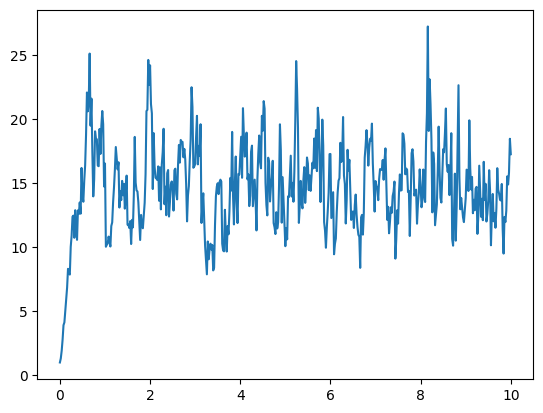

In [5]:
plt.plot(time1,tr1)

### Step 2

Now we are able to study the steady state probability distribution. It's quite simple: we will consider an uniform probability distribution for the starting $x_0$ and generated a certain number of simulations we will collect the final value in bins. This will need some work due to the potentially unlimited domain so we will need to do some progressive corrections

In [6]:
omega = [5,30] #0,100
Nbins = 250 #100
Nsim = 10000 #10000
k = (omega[1]-omega[0])/Nbins
system = PLS(15,1)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),5,1000)
    for i in range(Nbins):
        if ptraj[-1] < (k*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*k)

In [7]:
print(bins)
print(np.sum(bins))

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.    0.001 0.002 0.    0.001
 0.    0.001 0.002 0.003 0.005 0.006 0.004 0.001 0.006 0.009 0.009 0.011
 0.012 0.01  0.01  0.018 0.021 0.018 0.023 0.021 0.024 0.024 0.031 0.039
 0.033 0.029 0.044 0.048 0.044 0.057 0.055 0.062 0.074 0.07  0.072 0.072
 0.074 0.082 0.087 0.083 0.082 0.11  0.102 0.105 0.109 0.11  0.107 0.106
 0.11  0.123 0.122 0.124 0.129 0.121 0.154 0.109 0.131 0.139 0.136 0.147
 0.159 0.145 0.141 0.135 0.151 0.159 0.145 0.142 0.146 0.14  0.129 0.139
 0.132 0.121 0.141 0.132 0.139 0.122 0.132 0.132 0.121 0.122 0.132 0.138
 0.12  0.113 0.117 0.121 0.093 0.102 0.093 0.096 0.114 0.097 0.113 0.095
 0.065 0.072 0.077 0.072 0.062 0.073 0.072 0.061 0.06  0.056 0.057 0.051
 0.045 0.039 0.05  0.037 0.054 0.041 0.037 0.044 0.039 0.03  0.026 0.038
 0.029 0.03  0.031 0.025 0.016 0.02  0.017 0.014 0.02  0.022 0.015 0.02
 0.015 0.018 0.02  0.013 0.015 0.011 0.014 0.013 0.007 

<BarContainer object of 250 artists>

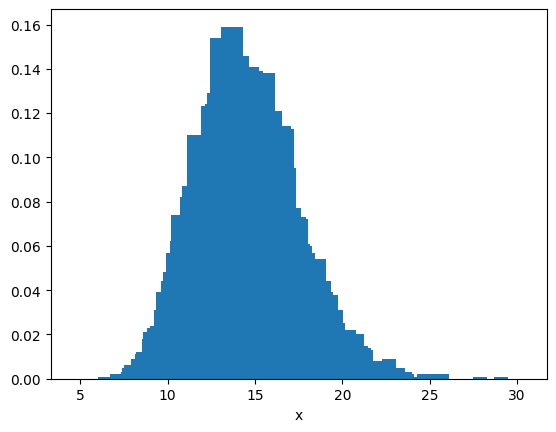

In [8]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")

plt.bar(x,bins)

### Step 3

In [9]:
A = 5.678987961480652177734375*10.0**(20)

In [10]:
P = lambda x: np.power(x,28)*np.exp(-2*x)/A

In [11]:
prob_dist = P(x)
print(prob_dist)

[2.97813482e-06 4.25107702e-06 6.00261619e-06 8.38782587e-06
 1.16036753e-05 1.58978999e-05 2.15791316e-05 2.90283310e-05
 3.87115370e-05 5.11939148e-05 6.71550437e-05 8.74053420e-05
 1.12903481e-04 1.44774584e-04 1.84328963e-04 2.33081075e-04
 2.92768361e-04 3.65369543e-04 4.53121943e-04 5.58537336e-04
 6.84415828e-04 8.33857231e-04 1.01026939e-03 1.21737296e-03
 1.45920206e-03 1.74010043e-03 2.06471259e-03 2.43796957e-03
 2.86506915e-03 3.35145008e-03 3.90276046e-03 4.52482006e-03
 5.22357683e-03 6.00505772e-03 6.87531421e-03 7.84036290e-03
 8.90612188e-03 1.00783434e-02 1.13625437e-02 1.27639306e-02
 1.42873305e-02 1.59371146e-02 1.77171264e-02 1.96306110e-02
 2.16801474e-02 2.38675848e-02 2.61939839e-02 2.86595640e-02
 3.12636573e-02 3.40046703e-02 3.68800540e-02 3.98862828e-02
 4.30188426e-02 4.62722291e-02 4.96399553e-02 5.31145700e-02
 5.66876853e-02 6.03500142e-02 6.40914177e-02 6.79009604e-02
 7.17669753e-02 7.56771352e-02 7.96185318e-02 8.35777601e-02
 8.75410090e-02 9.149415

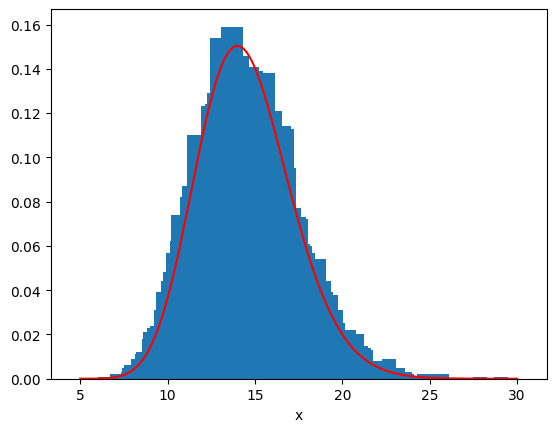

In [12]:
plt.xlabel("x")

plt.bar(x,bins)
plt.plot(x,prob_dist,color='r')